In [2]:
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt

from math import pi
from pathlib import Path 
from tabulate import tabulate
from shapely import Point, MultiPoint, LineString, affinity

In [3]:
file = Path().resolve()
parent, root = file.parent, file.parents[1]

# add the location of the root folder (zeroheliumkit) to the PATH
sys.path.append(str(root))

# Additionally remove the current file's directory from sys.path
try:
    sys.path.remove(str(parent))
except ValueError: # Already removed
    pass

In [42]:
from zeroheliumkit import Entity, Structure
from zeroheliumkit.geometries import *
from zeroheliumkit.helpers.resonator_calc import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

### **RES uChannels** 

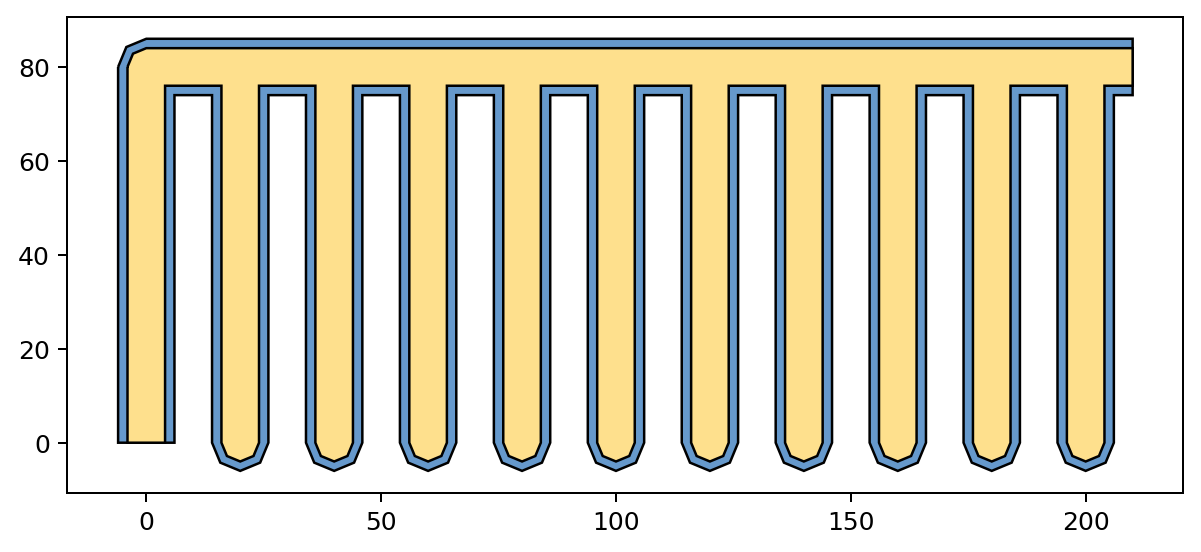

In [21]:
RES_layer_info = {"metal": 8,
                  "etch": 12}
reservior = uChannels(length = 80, 
                      spacing = 20, 
                      num = 9, 
                      layers=RES_layer_info)

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
reservior.plot(ax=ax, layer=["etch", "metal"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Taper**

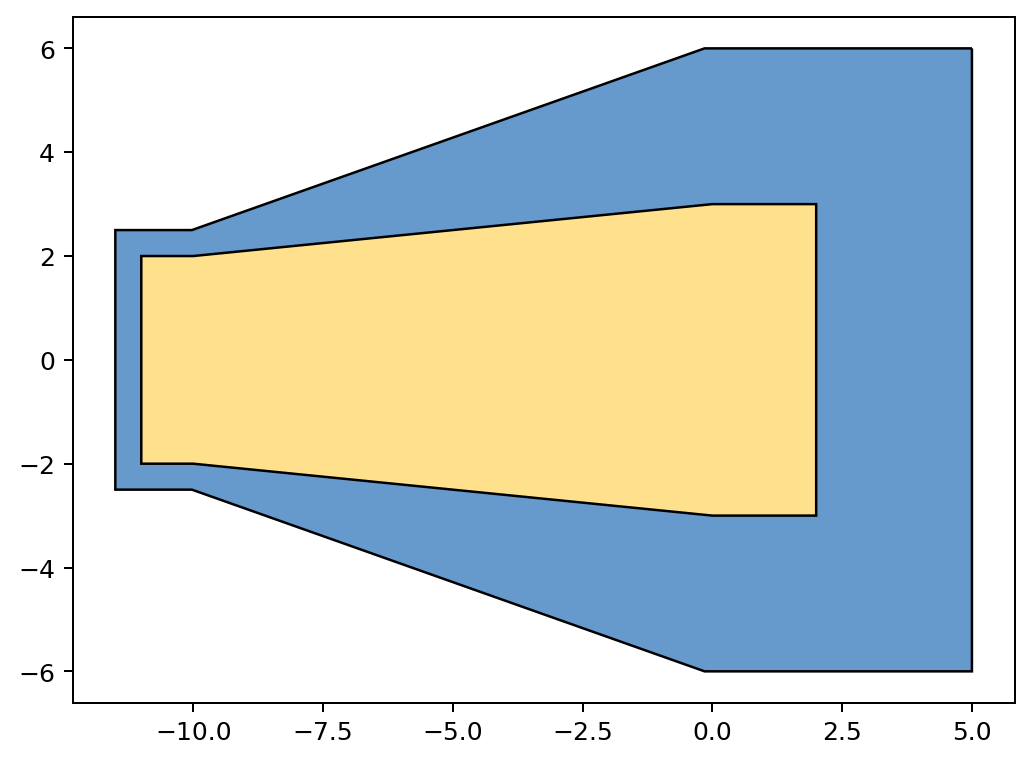

In [15]:
layer_info = {"metal": None,
              "etch": (3, 0.5)}
tp = Taper(length = 10, 
           width1 = 6, 
           width2 = 4, 
           input_length = 2, 
           output_length = 1,
           anchors = "flat", 
           layers = layer_info)
tp.scale(-1, 1, origin=(0,0))

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
tp.plot(ax=ax, layer=["etch", "metal"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Spiral Inductor** <a name="introduction"></a>

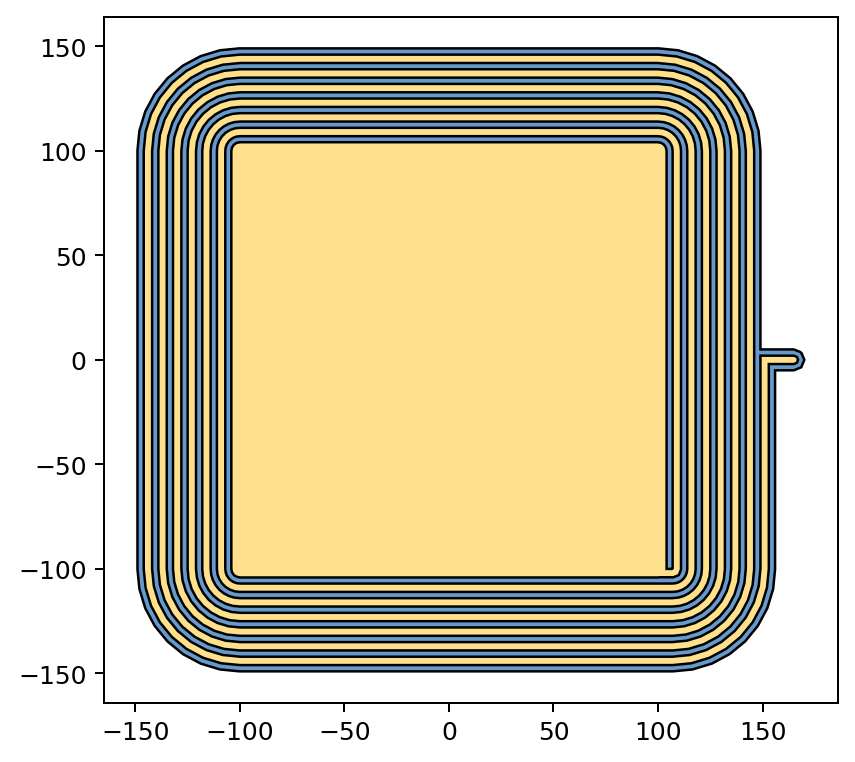

In [29]:
layer_info = {"metal": 4,
              "etch": 10}
spI = SpiralInductor(size = 200, 
                    width = 4, 
                    gap = 3, 
                    num_turns = 6, 
                    smallest_section_length = 0.5,
                    layers = layer_info)

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
spI.plot(ax=ax, layer=["etch", "metal"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()
#spI.save_to_file("spiral_inductor")

### **IDC**

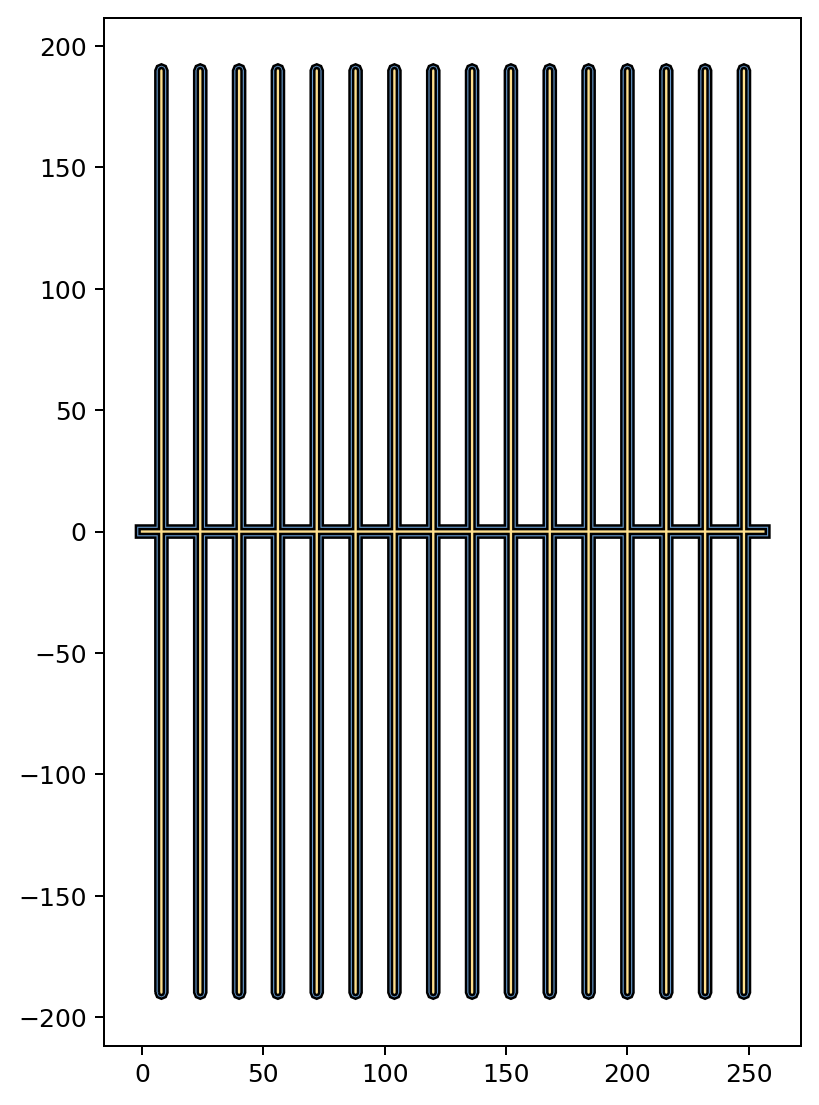

In [32]:
layer_info = {"metal": 2,
              "etch": 5}
idc = IDC(length = 190, 
          spacing = 16, 
          num = 15, 
          layers = layer_info)

fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
idc.plot(ax=ax, layer=["etch", "metal"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Straight Line**

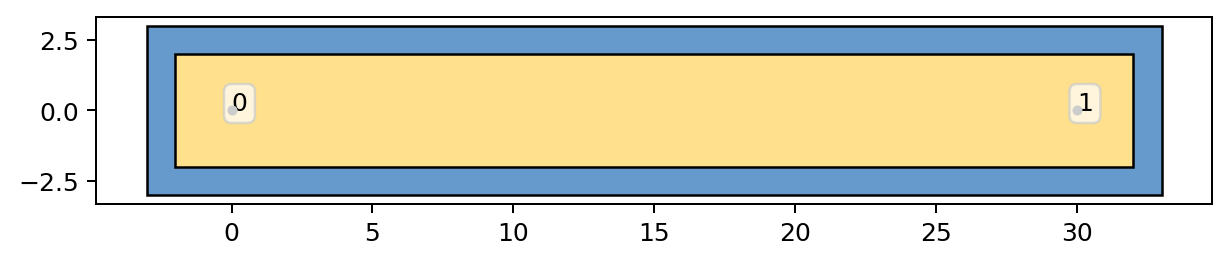

In [35]:
layer_info = {"metal": 4,
              "etch": 6}
line = StraightLine(length = 30,
                    layers = layer_info)

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
line.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Fillet**

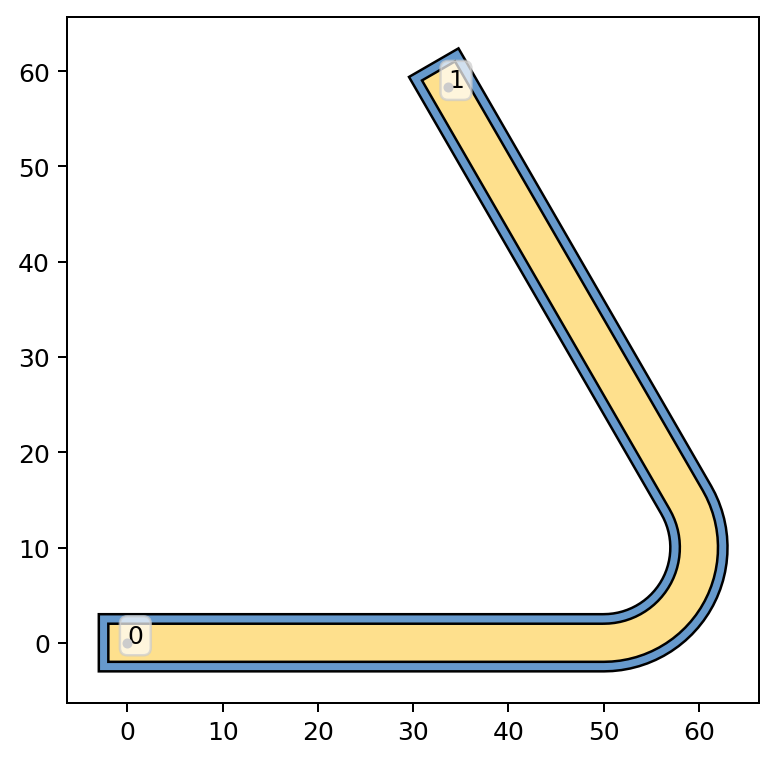

In [36]:
layer_info = {"metal": 4,
              "etch": 6}
fl = Fillet(length1=50, 
            length2=50, 
            radius=10, 
            direction=120, 
            num_segments=30, 
            layers=layer_info)

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
fl.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Route between 2 points**

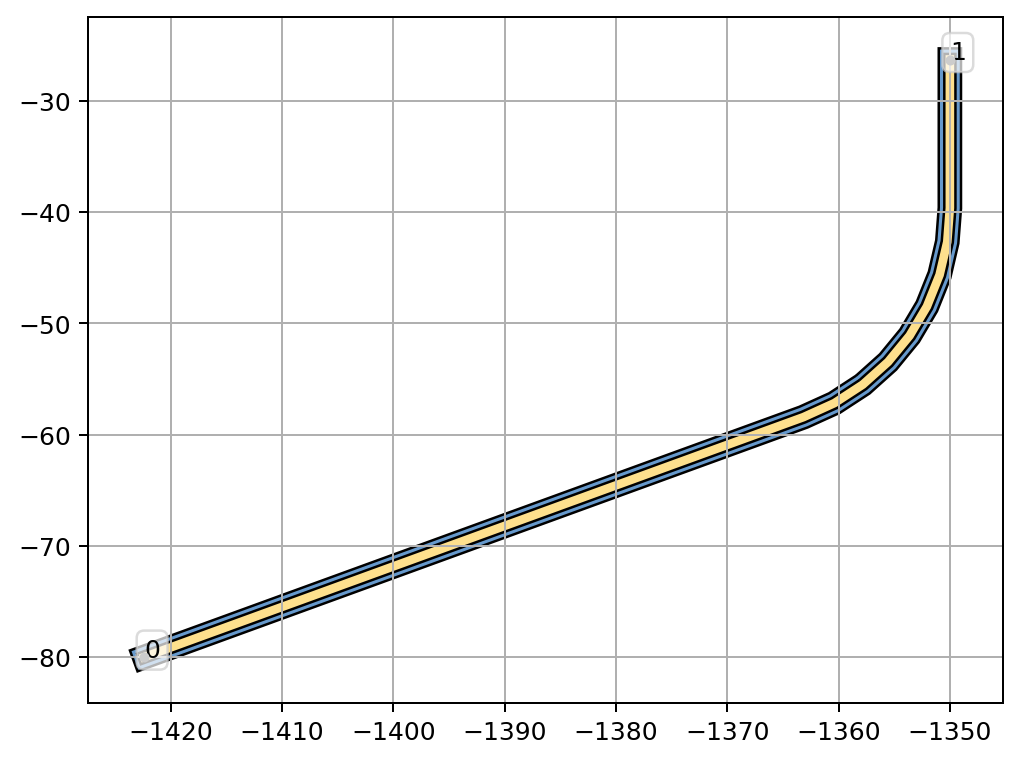

In [38]:
layer_info = {"metal": 1,
              "etch": 2}

p1 = Point (-1422.3998, -80)
p2 = Point(-1350, -26.3)

route = Route(p1, 20, p2, 90, radius=20, num_segments=9, layers=layer_info)

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
plt.grid()
route.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **RouteTwoElbows**

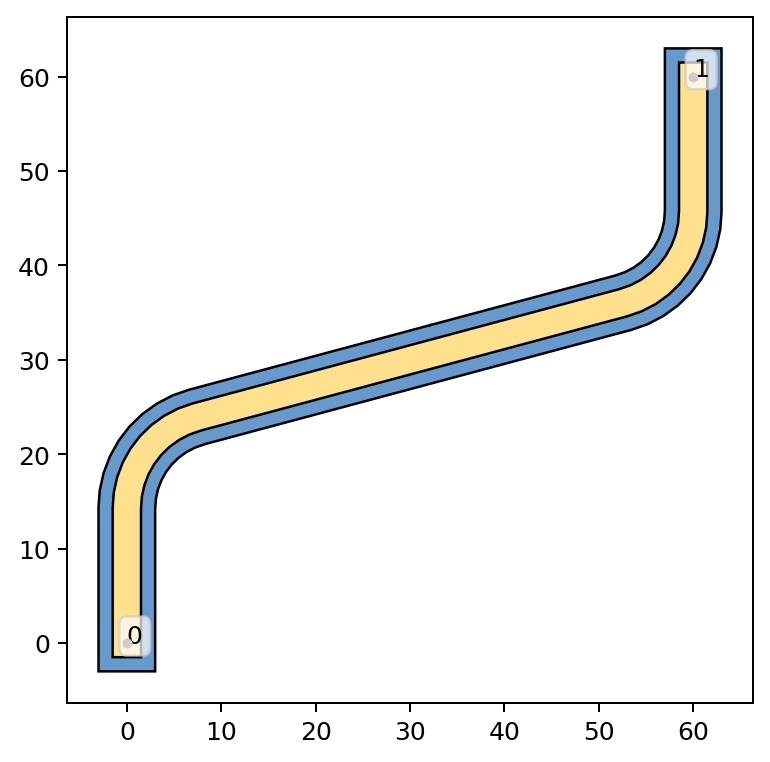

In [41]:
layer_info = {"metal": 3,
              "etch": 6}

p1 = Point(0, 0)
p2 = Point(60, 60)
r2 = RouteTwoElbows(p1, 90, p2, 90, 15, radius=10, num_segments=10, layers=layer_info)

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
r2.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **CPW Resontaor**

In [47]:
def construct_resonator_skeletone(params: dict, init_point: Point) -> LineString:
    
    r = params['geometry']['radius']
    n = params['geometry']['num']
    w = params['geometry']['w']
    g = params['geometry']['g']
    b_x = params['geometry']['box_x'] - 2 * r
    b_y = params['geometry']['box_y']/2 - r
    x0 = init_point.x
    y0 = init_point.y
    
    eps_eff = calculate_eps_eff_from_geometry(substrate_epsR = params["substrate_eps"],
                                              w = w,
                                              g = g,
                                              substrate_height = params["substrate_h"])
    Z0 = calculate_impedance(w, g, eps_eff)
    length = calculate_resonator_length(params["type"], eps_eff, params["frequency"])
    print(tabulate([["f0", "length", "eps_eff", "impedance"], 
                    [params["frequency"], round(length, 2), round(eps_eff, 2), round(Z0, 2)]]))
    
    d_e = b_y - 4 * r * n
    d_b = (length/2 - (b_y + pi * r + b_x + n * 2 * pi * r + d_e))/2/n
    if d_b < 0 or d_e < 0:
        raise Exception("Incorrect geometry input. Choose different 'radius', 'x_length', 'y_height' or 'num'")

   
    e = Entity()
    e.add_line(LineString([(x0, y0), (x0, b_y)]))
    e.add_line(ArcLine(r, 0, r, 180, 90, 50))
    e.add_line(LineString([(0, 0), (b_x - d_b/2, 0)]))
    for i in range(n):
        e.add_line(Meander(d_b, r, direction=-90, num_segments=100))
    e.add_line(LineString([(0, 0), (d_b/2, 0)]))
    e.add_line(ArcLine(0, -r, r, 90, 0, 50))
    e.add_line(LineString([(0, 0), (0, -d_e)]))

    e_mirrored = affinity.scale(e.skeletone, xfact=1, yfact=-1, origin=(0,0))

    return merge_lines_with_tolerance(e.skeletone, e_mirrored, tol=1e-2)

In [56]:
params = {'type': 0.5,
        'frequency': 6.5,
        'substrate_eps': 11,
        'substrate_h': 1500,
        'geometry': {'w': 10,
                        'g': 4.5,
                        'box_x': 1400, 
                        'box_y': 1200,
                        'radius': 60, 
                        'num': 2}}
geom_params = params["geometry"]
resonator_sk = construct_resonator_skeletone(params, Point(0, 20))

resonator = GeometryCollection(layers={"top": resonator_sk.buffer(geom_params["w"], cap_style="flat", join_style="mitre"),
                                       "gnd": resonator_sk.buffer(geom_params["w"] + 2*geom_params["g"], cap_style="flat", join_style="mitre")})

p1 = Point(0, 20)
p2 = Point(geom_params["box_x"] - geom_params["radius"], geom_params["box_y"]/2 - geom_params["radius"])

resonator.add_anchor([p1, p2])

---  -------  -------  ---------
f0   length   eps_eff  impedance
6.5  9414.63  6.0      47.72
---  -------  -------  ---------


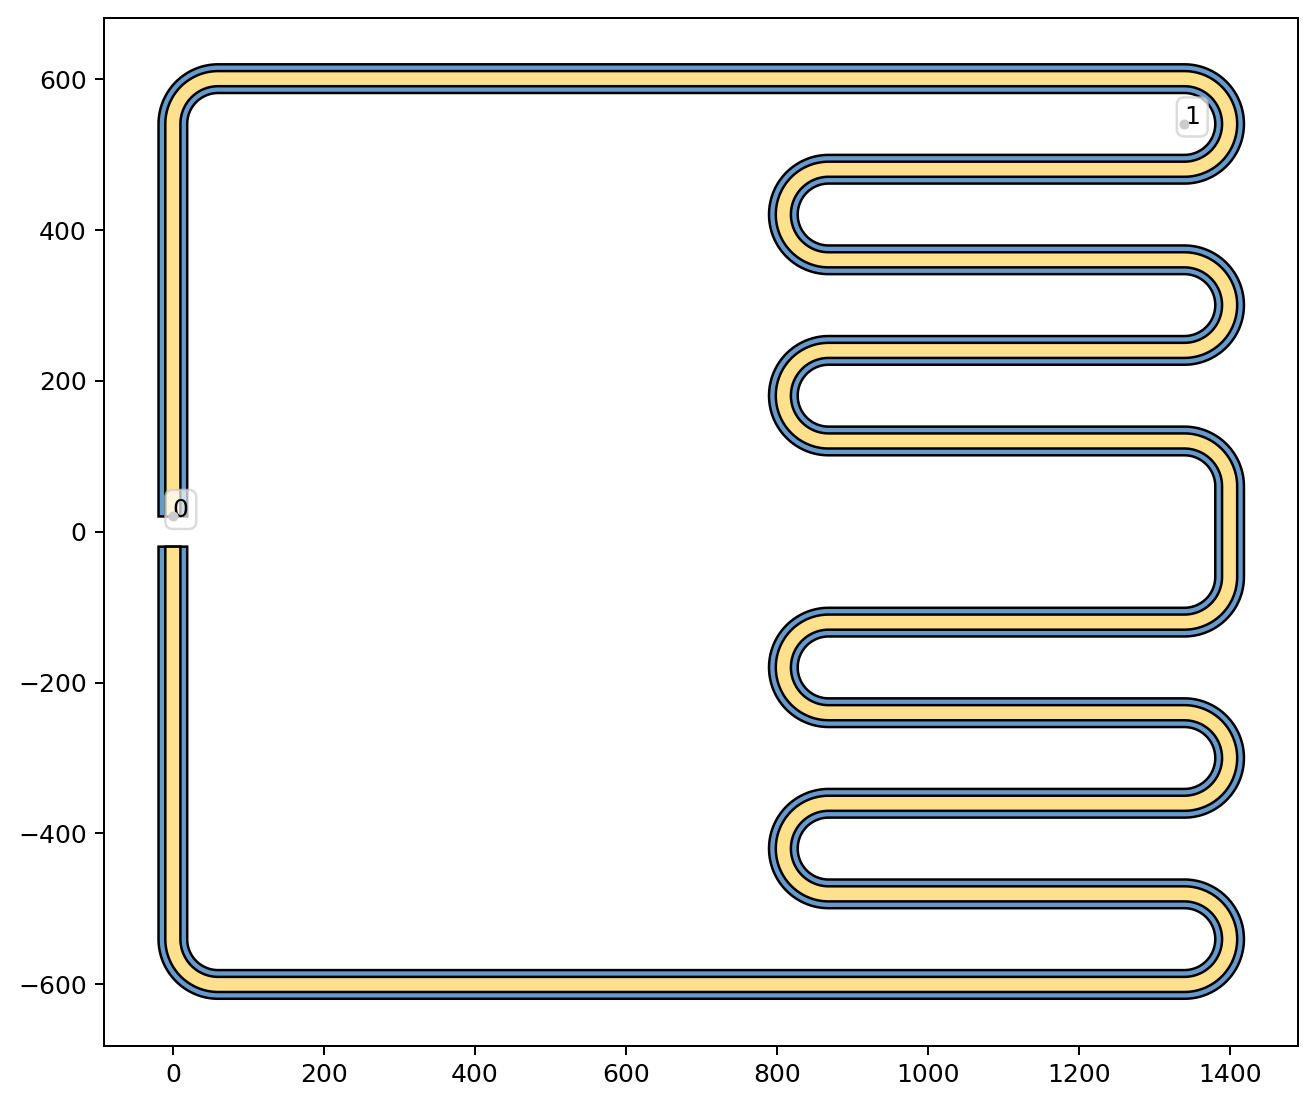

In [57]:
fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
resonator.plot(ax=ax, layer=["gnd", "top", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **CPW Launcher**

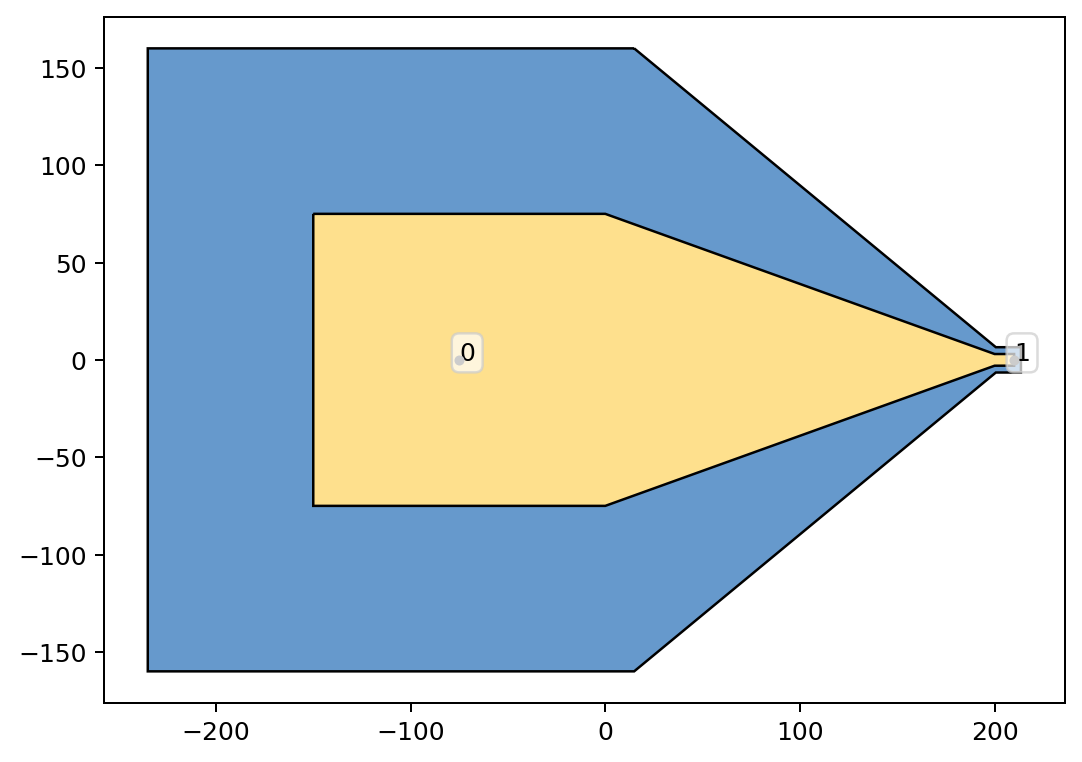

In [59]:
cpwlauncher = Taper(length = 200,
                    width1 = 150,
                    width2 = 6,
                    input_length = 150,
                    output_length = 10,
                    anchors = "flat",
                    layers = {"top": None,
                              "gnd": (85, 3.5)})
cpwlauncher.anchors = MultiPoint([Point(-150/2, 0), cpwlauncher.anchors.geoms[1]])
cpwlauncher.skeletone = LineString()

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
cpwlauncher.plot(ax=ax, layer=["gnd", "top", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()